In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import pytorch_lightning as pl

sns.set_theme(style="whitegrid", font_scale=1.2, palette="muted")

Text(0, 0.5, '')

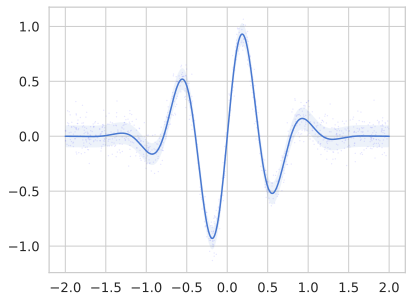

In [3]:
n = 1000
x = torch.linspace(-2, 2, 2*n)
p, q, r = 0, 2, 4
y = torch.sin(p + r * q * x) * torch.exp(-(p + r * q * x)**2/32.0)
std = 0.1

ids = np.random.choice(torch.arange(len(x)), n)
X = x[ids]
Y = y[ids] + np.random.normal(0, std, n)

dataset = torch.utils.data.TensorDataset(X.unsqueeze(1), Y.unsqueeze(1))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

sns.lineplot(x=x, y=y)
plt.fill_between(x, y - std, y + std, alpha=0.10)
sns.scatterplot(x=X, y=Y, color="blue", s=2, alpha=0.10)
plt.xlabel("")
plt.ylabel("")

In [4]:
class HomoscedasticRegressionModel(pl.LightningModule):
    def __init__(self):
        super(HomoscedasticRegressionModel, self).__init__()
        self.hidden1 = nn.Linear(1, 30)
        self.hidden2 = nn.Linear(30, 50)
        self.relu = nn.ReLU()
        self.mu = nn.Linear(50, 1)
        self.sigma = nn.Parameter(torch.ones(1))

    def forward(self, x):
        h = self.relu(self.hidden1(x))
        h = self.relu(self.hidden2(h))
        µ = self.mu(h)
        σ = self.sigma
        return µ, σ

    def univariate_homoscedastic_regression_loss(self, y_true, y_pred):
        µ, σ = y_pred
        return -torch.distributions.Normal(µ, torch.max(σ, torch.tensor(1e-6))).log_prob(y_true).mean()

    def training_step(self, batch, batch_idx):
        X_batch, Y_batch = batch
        return self.univariate_homoscedastic_regression_loss(Y_batch, self(X_batch))

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=0.002)

# Instantiate the model
model = HomoscedasticRegressionModel()

# Create a DataLoader
dataset = torch.utils.data.TensorDataset(X.reshape(-1,1), Y.reshape(-1,1))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

# Instantiate the PyTorch Lightning trainer
trainer = pl.Trainer(max_epochs=100)

# Train the model
trainer.fit(model, dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /home/ventus/foo/lightning_logs
2025-01-03 17:47:54.143758: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-03 17:47:54.154645: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-03 17:47:54.157970: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-03 17:47:54.167230: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performan

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


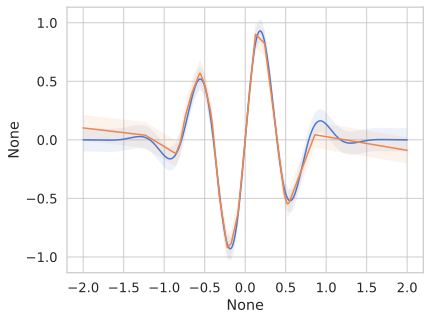

In [6]:
model.eval()
µ, σ = model(x.unsqueeze(1))
µ = µ.detach().squeeze()
σ = σ.detach().squeeze()
sns.lineplot(x=x, y=y)
plt.fill_between(x, y - std, y + std, alpha=0.10)
sns.lineplot(x=x, y=µ)
plt.fill_between(x, µ - σ, µ + σ, alpha=0.10)

In [7]:
σ

tensor(0.1123)